In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sn

train_dataset1 = np.genfromtxt(r"dataset\Dataset_2A\forest\train.csv",delimiter=',')
feature_train1 = train_dataset1[1:,1:25]
class_train1 = [0]*len(feature_train1)
train_dataset2 = np.genfromtxt(r"dataset\Dataset_2A\highway\train.csv",delimiter=',')
feature_train2 = train_dataset2[1:,1:25]
class_train2 = [1]*len(feature_train2)
train_dataset3 = np.genfromtxt(r"dataset\Dataset_2A\insidecity\train.csv",delimiter=',')
feature_train3 = train_dataset3[1:,1:25]
class_train3 = [2]*len(feature_train3)
train_dataset4 = np.genfromtxt(r"dataset\Dataset_2A\mountain\train.csv",delimiter=',')
feature_train4 = train_dataset4[1:,1:25]
class_train4 = [3]*len(feature_train4)
train_dataset5 = np.genfromtxt(r"dataset\Dataset_2A\street\train.csv",delimiter=',')
feature_train5 = train_dataset5[1:,1:25]
class_train5 = [4]*len(feature_train5)

feature_train = np.concatenate([feature_train1,feature_train2,feature_train3,feature_train4,feature_train5])
class_train = np.concatenate([class_train1,class_train2,class_train3,class_train4,class_train5])

dev_dataset1 = np.genfromtxt(r"dataset\Dataset_2A\forest\dev.csv",delimiter=',')
feature_dev1 = dev_dataset1[1:,1:25]
class_dev1 = [0]*len(feature_dev1)
dev_dataset2 = np.genfromtxt(r"dataset\Dataset_2A\highway\dev.csv",delimiter=',')
feature_dev2 = dev_dataset2[1:,1:25]
class_dev2 = [1]*len(feature_dev2)
dev_dataset3 = np.genfromtxt(r"dataset\Dataset_2A\insidecity\dev.csv",delimiter=',')
feature_dev3 = dev_dataset3[1:,1:25]
class_dev3 = [2]*len(feature_dev3)
dev_dataset4 = np.genfromtxt(r"dataset\Dataset_2A\mountain\dev.csv",delimiter=',')
feature_dev4 = dev_dataset4[1:,1:25]
class_dev4 = [3]*len(feature_dev4)
dev_dataset5 = np.genfromtxt(r"dataset\Dataset_2A\street\dev.csv",delimiter=',')
feature_dev5 = dev_dataset5[1:,1:25]
class_dev5 = [4]*len(feature_dev5)

dev_dataset = np.concatenate([feature_dev1,feature_dev2,feature_dev3,feature_dev4,feature_dev5])
dev_class = np.concatenate([class_dev1,class_dev2,class_dev3,class_dev4,class_dev5])

class_count = 5
d = len(feature_train[0])

feature_test = np.zeros((int(len(dev_dataset)/2),d))
class_test = np.zeros(int(len(dev_dataset)/2))
feature_dev = np.zeros((int((len(dev_dataset)+1)/2),d))
class_dev = np.zeros(int((len(dev_dataset)+1)/2))
for i in range(len(dev_dataset)):
    if i%2:
        feature_test[int((i-1)/2)] = dev_dataset[i]
        class_test[int((i-1)/2)] = dev_class[i]
    else:
        feature_dev[int(i/2)] = dev_dataset[i]
        class_dev[int(i/2)] = dev_class[i]

In [2]:
def printheatmap(c):
    sn.heatmap(c,annot=True)
    plt.show() 

In [3]:
def Euclidean_distance(data1,data2):
    return math.sqrt(sum((data1-data2)**2))

In [4]:
def gaussianPrabability(data,mean,cov):
    cov += ((10**(-6))*(np.identity(d))) 
    u = data-mean
    exp = -0.5*(u.transpose().dot(np.linalg.inv(cov)).dot(u)) -(d/2)*np.log(2*math.pi) -0.5*np.log(np.linalg.det(cov))
    return math.e**(exp)

In [5]:
def assignCluster(mean,data,k):
    z = np.zeros((len(data),k))
    for i in range(len(data)):
        closest = Euclidean_distance(data[i],mean[0])**2
        z[i][0] = 1
        for j in range(len(mean)):
            dist = Euclidean_distance(data[i],mean[j])**2
            if(dist < closest):
                closest = dist
                z[i] = np.zeros(k)
                z[i][j] = 1
    return z

In [6]:
def updateMean(z,data,k):
    mean = np.zeros((k,d))
    N = sum(z)
    for i in range(k):
        for j in range(len(data)):
            mean[i]+=data[j]*z[j][i]
        mean[i]/=N[i]
    return mean

In [7]:
def updateCov(z,data,k,mean):
    N = sum(z)
    cov = [np.zeros((d,d)) for rows in range(k)]
    for i in range(k):
        for j in range(len(data)):
            u = data[j]-mean[i]
            cov[i]+= z[j][i]*np.outer(u,u.transpose())
        cov[i]/=N[i]
    return cov

In [8]:
def KmeansClustering(k,data,iteration):
    mean = np.zeros((k,d))
    mean_index_initial = np.random.choice(len(data),k)    
    for i in range(k):
        mean[i] = data[mean_index_initial[i]]
    z_old = assignCluster(mean,data,k)
    for i in range(iteration):
        mean = updateMean(z_old,data,k)
        z_new = assignCluster(mean,data,k)
        if np.allclose(z_new,z_old):
            break
        z_old = z_new
    return mean

In [9]:
def likelihood(k,w,data,mean,cov):
    likelihood = 0
    for i in range(k):
        likelihood += w[i]*gaussianPrabability(data,mean[i],cov[i])
    return likelihood

In [10]:
def totalLogLikelihood(data,k,w,mean,cov):
    totalLikelihood = 0
    for i in range(len(data)):
        totalLikelihood += np.log(likelihood(k,w,data[i],mean,cov))
    return totalLikelihood

In [11]:
def ExpectationStep(data,k,w,mean,cov):
    z = np.zeros((len(data),k))
    for i in range(len(data)):
        denominator = 0
        for j in range(k):
            z[i][j] = w[j]*gaussianPrabability(data[i],mean[j],cov[j])
            denominator+=z[i][j]
        z[i]/=denominator
    return z

In [12]:
def GMM(data,k):
    iteration = 1000
    mean = KmeansClustering(k,data,iteration)
    gamma_old = assignCluster(mean,data,k)
    N = sum(gamma_old)
    w = N/sum(N)
    mean = updateMean(gamma_old,data,k)
    cov = updateCov(gamma_old,data,k,mean)
    print(N)
    totalLikelihood_old = totalLogLikelihood(data,k,w,mean,cov) 
    threshold = 0.01
    for i in range(iteration):
        gamma_new = ExpectationStep(data,k,w,mean,cov)
        gamma_old = gamma_new
        mean = updateMean(gamma_old,data,k)
        cov = updateCov(gamma_old,data,k,mean)
        N = sum(gamma_old)
        w = N/sum(N)
        totalLikelihood_new = totalLogLikelihood(data,k,w,mean,cov) 
        if(totalLikelihood_new - totalLikelihood_old < threshold):
            break
        totalLikelihood_old = totalLikelihood_new
    return w,mean,cov

In [13]:
def getParameters(data,label,k):
    class_dist = [[]for rows in range(class_count)]
    w = [ np.zeros(Q) for rows in range(class_count)]
    mean = [ np.zeros((k,d)) for rows in range(class_count)]
    cov = [ [np.zeros((d,d)) for cols in range(k)] for rows in range(class_count)]
    p_class = np.zeros(class_count)
    for i in range(len(data)):
        class_dist[int(label[i])].append(data[i])
    for i in range(class_count):
        w[i],mean[i],cov[i] = GMM(class_dist[i],k)
        p_class[i] = len(class_dist[i])/len(data)
    return w,mean,cov,p_class

In [14]:
def diagonalize(cov):
    for i in range(d):
        for j in range(d):
            if(i!=j):
                cov[i][j] = 0
    return cov

In [15]:
def BayesClassifier(data,label,Q,w,mean,cov,p_class,mode):
    if(mode == 0):
        for i in range(class_count):
            for j in range(Q):
                cov[i][j] = diagonalize(cov[i][j])

    p = np.zeros((len(data),class_count))
    for i in range(class_count):
        for j in range(len(data)):
            p[j][i] = np.log(likelihood(Q,w[i],data[j],mean[i],cov[i]))+np.log(p_class[i])
    
    predicted = np.zeros(len(data))
    confusion_matrix = np.zeros((class_count,class_count))
    for i in range(len(data)):
        predicted[i] = np.where(p[i]==max(p[i]))[0][0]
        confusion_matrix[int(predicted[i])][int(label[i])]+=1
    return confusion_matrix

[21. 22. 27. 24. 27. 36.  9. 18. 40.  5.]
[28. 33. 20. 18. 12.  8.  4. 24. 18. 17.]
[40.  1. 47.  1. 12. 28.  7. 23. 39. 17.]
[50. 23. 15. 33. 18. 25. 25. 25. 25. 22.]
[31. 26. 14.  9. 28. 30. 19. 20. 23.  4.]


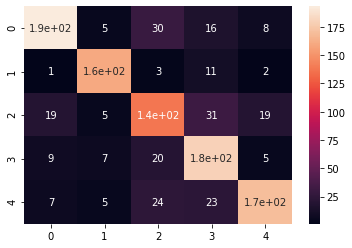

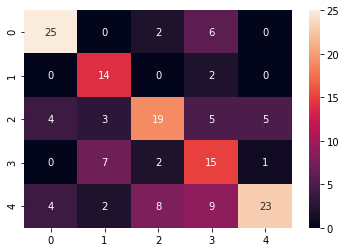

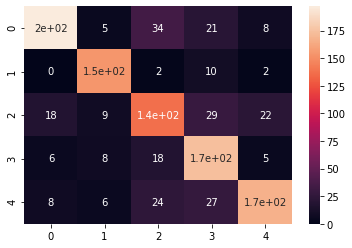

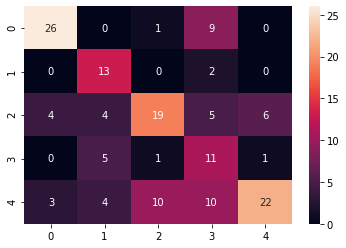

(array([77.0852429 , 75.98533456]),
 array([61.78343949, 61.14649682]),
 array([61.53846154, 58.33333333]))

In [16]:
Q=10
w,mean,cov,p_class = getParameters(feature_train,class_train,Q)
accuracy_dev = np.zeros(2)
accuracy_train = np.zeros(2)
accuracy_test = np.zeros(2)
for i in range(2):
    confusion_matrix = BayesClassifier(feature_train,class_train,Q,w,mean,cov,p_class,i)
    printheatmap(confusion_matrix)
    accuracy_train[i] = np.trace(confusion_matrix)/len(feature_train)*100
    confusion_matrix = BayesClassifier(feature_dev,class_dev,Q,w,mean,cov,p_class,i)
    accuracy_dev[i] = np.trace(confusion_matrix)/len(feature_dev)*100
    confusion_matrix = BayesClassifier(feature_test,class_test,Q,w,mean,cov,p_class,i)
    accuracy_test[i] = np.trace(confusion_matrix)/len(feature_test)*100
    printheatmap(confusion_matrix)
accuracy_train,accuracy_dev,accuracy_test